In [1]:
'''
This file finds out the important descriptors involved in the feature selection for
    - STUDY1
    - STUDY2 data
'''

'\nThis file finds out the important descriptors involved in the feature selection for\n    - STUDY1\n    - STUDY2 data\n'

In [2]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

In [3]:
def getFeatures(df ,model,factor_loadings_path=None,isPC=True,target='PQ',n_components=3):
    '''
    Find the 30 most important predictors
    in case of PC its find out the 30 most important predictors from the best PCs selected
    In case of original features 30 most important predictors are taken into consideration
    '''
    features_list_by_models=[]
    
    df = df[df['Target']==target]
    temp = df[df['Algorithm']==model]
    if 'Features' in temp:
        x3= temp['Features']
        if(model == 'MARS' and isPC==True):
            x3= temp['Features'].values[0].replace('PC','').split(',')
            for i in range(0, len(x3)):
                x3[i] =str(int(x3[i])-1)
        elif(model != 'MARS' and isPC==True):
            x3 = x3.values[0].replace('  ',' ').replace('[','').replace(']','').replace('\n','').replace('\r','').strip().split(' ')
        elif(model=='MARS' and isPC==False):
            x3 = x3.values[0].split(',')
        else:
            x3= x3.values[0].replace('\'', '').replace('[','').replace(']','').replace('\n','').replace('\r','').split(' ')
    else:
        x3=np.arange(0,n_components)
        x3 = [str(x) for x in x3]
        
    x3_features=[]
    temp=[]
    if(isPC==True):
        # find the features of each PC and compute its mean accross selected PCs
        # Depending on the mean value, select 30 best features.
        df_factor_loadings = pd.read_csv(factor_loadings_path,index_col=0)
        features = df_factor_loadings[x3].mean(axis=1).nlargest(30).index.values
#         temp = pd.DataFrame(data={"Features":df_factor_loadings[x3].mean(axis=1).nlargest(30).index.values,"Mean":df_factor_loadings[x3].mean(axis=1).nlargest(30).values})
#         print(temp)
#         features = df_factor_loadings[x3].mean(axis=1).index.values
        features_list_by_models.append(features)
    else:
        x3=x3[:30] # select top 30 predictors
        features_list_by_models.append(x3)
    return features_list_by_models[0]

In [4]:
def getDescriptors(df,dict_factor_loadings=None,isPC=True,target='PQ'):
    '''
        Since the features are the statistical summarization, get the descriptors out of the features
        e.g. touch.duration_mean belongs to the descriptor touch.duration
        Returns a dataframe containing the descriptors and the count of its statistical derivaties selected.
        
    '''
    descriptors_list_by_models=[]
    
    models = ['SVM','Random Forest','MARS','Linear regression', 'Elastic Net','Lasso Regression']
    for model in models:
        features_list_by_models=getFeatures(df,model,dict_factor_loadings,isPC,target)
#         print(features_list_by_models)
#         print(features_list_by_models)
        descriptors = ','.join(features_list_by_models).replace('_mean','').replace('_median','') \
                .replace('_kurt','').replace('_skew','').replace('_quantile','').replace('_std','') \
                .replace('_min','').replace('_count','').replace('_max','').replace('_mad','').split(',')
#         print(descriptors)
        descriptors_list_by_models.append(descriptors)
    
    data = pd.concat([pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[0])),orient='index',columns=['SVM']),
              pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[1])),orient='index',columns=['RF']),
              pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[2])),orient='index',columns=['MARS']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[3])),orient='index',columns=['LR']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[4])),orient='index',columns=['ElasticNet']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[5])),orient='index',columns=['Lasso'])
                     ],axis=1)
    data = data.fillna(0)
    data['Descriptors']=data.index
    return data

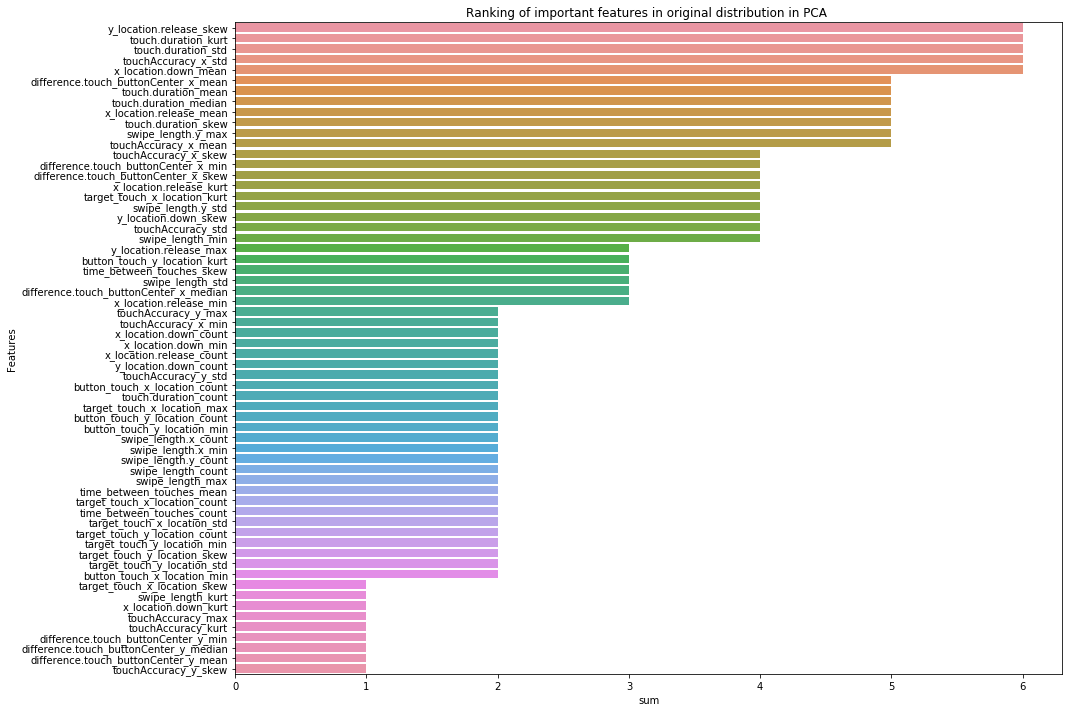

In [5]:
factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
features_list_by_models=[]
models = ['SVM','Random Forest','MARS','Linear regression', 'Elastic Net','Lasso Regression']
for model in models:
    features_list_by_models.append(getFeatures(df ,model,factor_loadings_path,isPC=True))
data = pd.concat([pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[0])),orient='index',columns=['SVM']),
              pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[1])),orient='index',columns=['RF']),
              pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[2])),orient='index',columns=['MARS']),
            pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[3])),orient='index',columns=['LR']),
            pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[4])),orient='index',columns=['ElasticNet']),
            pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[5])),orient='index',columns=['Lasso'])
                     ],axis=1)

data = data.fillna(0)
data['Features']=data.index
plt.figure(figsize=(15,10))
data['sum']=data.sum(axis=1)
sns.barplot(x='sum',y='Features',data=data.sort_values(by='sum', ascending=False))
plt.title('Ranking of important features in original distribution in PCA ')
plt.tight_layout()

In [6]:
features_list_by_models
descriptors_list_by_models=[]
for features_list_by_model in features_list_by_models:
    descriptors = ','.join(features_list_by_model).replace('_mean','').replace('_median','') \
                    .replace('_kurt','').replace('_skew','').replace('_quantile','').replace('_std','') \
                    .replace('_min','').replace('_count','').replace('_max','').replace('_mad','').split(',')
    #         print(descriptors)
    descriptors_list_by_models.append(descriptors)
    
data = pd.concat([pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[0])),orient='index',columns=['SVM']),
              pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[1])),orient='index',columns=['RF']),
              pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[2])),orient='index',columns=['MARS']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[3])),orient='index',columns=['LR']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[4])),orient='index',columns=['ElasticNet']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[5])),orient='index',columns=['Lasso'])
                     ],axis=1)
data = data.fillna(0)
# data[data['MARS']]
data['MARS']

button_touch_x_location            1.0
button_touch_y_location            1.0
difference.touch_buttonCenter_x    3.0
difference.touch_buttonCenter_y    0.0
swipe_length                       2.0
swipe_length.x                     1.0
swipe_length.y                     1.0
target_touch_x_location            3.0
target_touch_y_location            1.0
time_between_touches               2.0
touch.duration                     4.0
touchAccuracy                      0.0
touchAccuracy_x                    2.0
touchAccuracy_y                    0.0
x_location.down                    3.0
x_location.release                 3.0
y_location.down                    1.0
y_location.release                 2.0
Name: MARS, dtype: float64

In [7]:
def plot(data,title,groupbyCol='Descriptors'):
    
    means = data.groupby(by=groupbyCol).mean().fillna(0).reset_index()
    
    
    sd  = data.groupby(by=groupbyCol).std().fillna(0).reset_index()
    

    
    labels = means[groupbyCol]
    
    svm_means =means['SVM']
#     print(svm_means)
    svm_sd = sd['SVM']#/np.sqrt(6)
#     print(svm_means)
#     print(svm_sd)
    
    ind = np.arange(len(means))  # the x locations for the groups
    width = 0.15      # the width of the bars
    
    colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    fig, ax = plt.subplots(figsize=(20,10))
    rects1 = ax.bar(ind, svm_means, width, color=colors[0]
                    ,yerr=svm_sd,capsize=5
                   )


    rf_means = means['RF']
    rf_sd= sd['RF']#/np.sqrt(6)
    rects2 = ax.bar(ind + width, rf_means, width, color=colors[1], 
                    yerr=rf_sd,capsize=5
                   )

    mars_means = means['MARS']
    mars_sd=sd['MARS']#/np.sqrt(6)
    rects3 = ax.bar(ind + 2*width, mars_means, width, color=colors[2],
                    yerr=mars_sd,capsize=5
                   )

    lr_means = means['LR']
    lr_sd=sd['LR']#/np.sqrt(6)
#     rects4 = ax.bar(ind - width, lr_means, width, color=colors[3],
#                     yerr=lr_sd,capsize=5
#                    )
    
    enet_means = means['ElasticNet']
    enet_sd=sd['ElasticNet']#/np.sqrt(6)
#     rects5 = ax.bar(ind - 2*width, enet_means, width, color=colors[4],
#                     yerr=enet_sd,capsize=5
#                    )
    
    lasso_means = means['Lasso']
    lasso_sd=sd['Lasso']#/np.sqrt(6)
#     rects6 = ax.bar(ind - 3*width, lasso_means, width, color=colors[5],
#                     yerr=lasso_sd,capsize=5
#                    )
    
#     # add some text for labels, title and axes ticks
    ax.set_ylabel('Mean')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.set_xlabel(groupbyCol)
#     ax.tick_params(direction='out', length=6, width=2, colors='r',
#                    grid_color='r', grid_alpha=0.5)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")
    plt.tight_layout()
#     ax.legend((rects1[0], rects2[0],rects3[0], rects4[0],rects5[0],rects6[0]), ('SVM', 
#                                                                                 'Random Forest','MARS','Linear regression','Elastic Net',
#                                                                                 'Lasso'))
    ax.legend((rects1[0], rects2[0],rects3[0]), ('SVM', 
                                                                                'Random Forest','MARS'))
    plt.show()


Study1
---

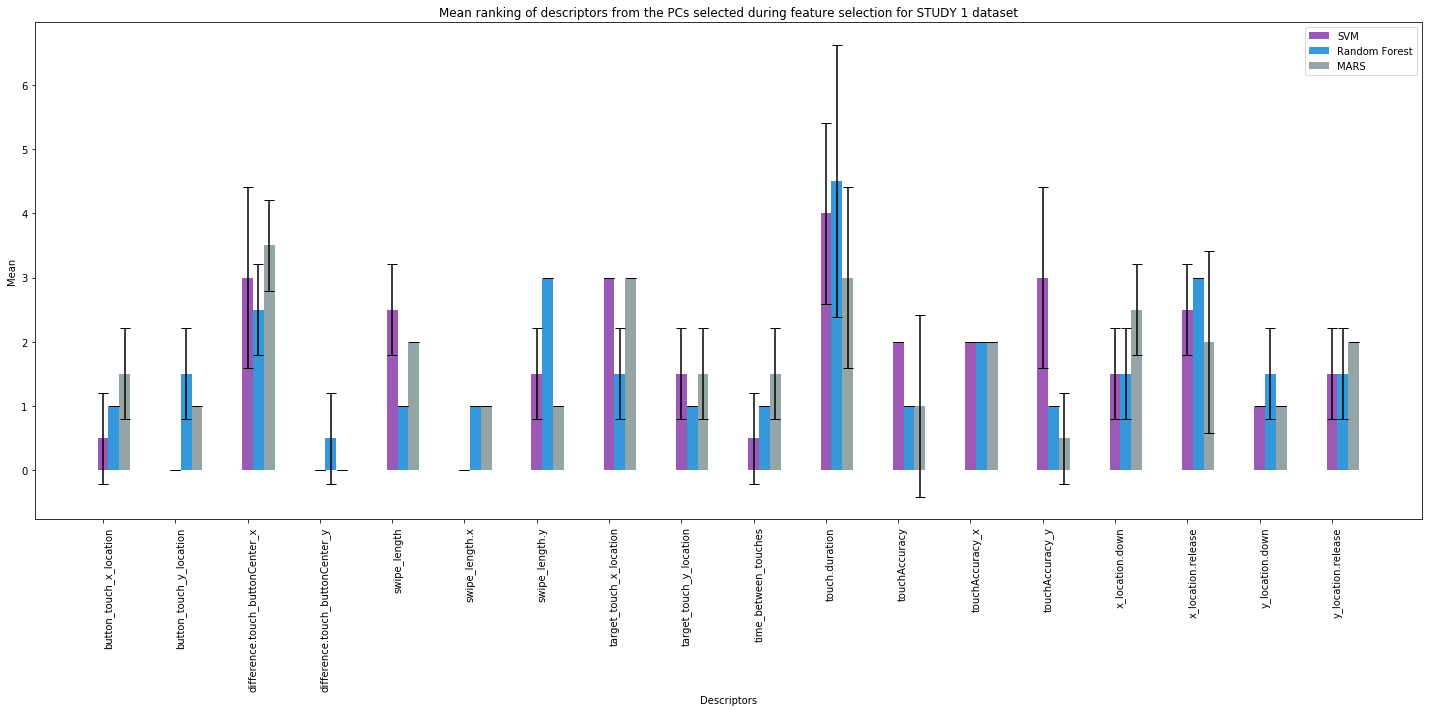

In [8]:
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets.csv')
descriptors_details_by_models_1 = getDescriptors(df,isPC=False)
descriptors_details_by_models_1['Method']='GA_original'

df = pd.read_csv('study1_feature_selection_mahalanobis_transformed_alltargets.csv')
descriptors_details_by_models_2 = getDescriptors(df,isPC=False)
descriptors_details_by_models_2['Method']='GA_transformed'


# plot_df = pd.concat([descriptors_details_by_models_1,
#            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

# title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 1 dataset'
# plot(plot_df,title)

factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'
# 
factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'

factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_5 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_5['Method']='GA_original_0.95PC'

factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_transformed_alltargets_PCA_0.95PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_6 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_6['Method']='GA_transformed_0.95PC'

plot_df = pd.concat([#descriptors_details_by_models_1,
           #descriptors_details_by_models_2,
          descriptors_details_by_models_3,
#           descriptors_details_by_models_4,
             descriptors_details_by_models_5,
#                descriptors_details_by_models_6
])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

title='Mean ranking of descriptors from the PCs selected during feature selection for STUDY 1 dataset'
plot(plot_df,title)

In [19]:
def generate_heatmap_fs(descriptors, descriptors_count,title,axes=None):
#     fig,axes = plt.subplots(figsize=(6,8))
    models=['First Best Model','Second Best Model']
    im = axes.imshow(descriptors_count,cmap="RdBu_r",vmin=1,vmax=5)
#     print(descriptors_count)
    axes.set_xticks(np.arange(len(models)))
    axes.set_yticks(np.arange(len(descriptors)))
    axes.set_xticklabels(models)
    axes.set_yticklabels(descriptors)
    fig.colorbar(im , ax=axes)
    # axes[0][0].clim(-1, 1)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(descriptors)):
        for j in range(len(models)):
            text = axes.text(j, i, descriptors_count[i, j],
                           ha="center", va="center", color="black",weight='bold')
    axes.set_title(title,weight='bold')
    return axes

def display_fs_count(descriptors,descriptors_count,models,axis_title,label_color,axes=None):
    df=pd.DataFrame()
    for i in range(len(descriptors_count)):
        data={'count':descriptors_count[i],'descriptors':descriptors,'model':models[i]}
        df=df.append(pd.DataFrame(data=data),ignore_index=True)

    # plot bar graph
    sns.barplot(x='count',y='descriptors',hue='model',data=df, palette=label_color, ax=axes)
    axes.set_title(axis_title, weight='bold')
    return axes

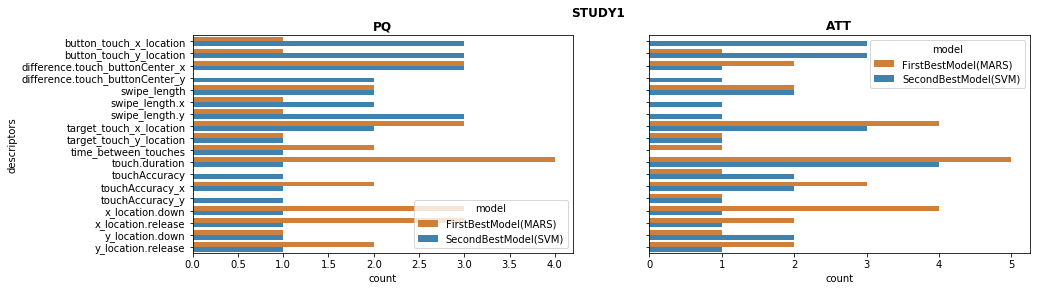

In [39]:
'''
TODO: plot the features only for 2 best models
for PQ and ATT seperately
and then check in combination
'''

## for PQ
target='PQ'
factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'
# 
factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
# df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
df =pd.read_csv('study1_PCA_alltargets_mahalanobis_3PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
# descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'
descriptors_details_by_models_4['Method']='PCA_3PC'


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4), sharey=True)
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('First Best model for PQ')

# sns.barplot(x='Descriptors',y='SVM',data=descriptors_details_by_models_3.sort_values(by='SVM', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('Second best model for PQ')

# fig.suptitle('Ranking of important features for two best models for PQ',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# # print(mars.nlargest(7,'MARS')['MARS'])
# svm = descriptors_details_by_models_4.sort_values(by='SVM', ascending=False)
# best2 = svm[svm['SVM']>1]['Descriptors'].values
# # print(mars.nlargest(7,'SVM')['SVM'])
# # best2 = svm.nlargest(7,'SVM')['Descriptors']
# print("Common features selected for PQ are:\n",set(best1)&(set(best2)))
fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
fs_scores.append(list(descriptors_details_by_models_4['SVM'].values))
descriptors=descriptors_details_by_models_3.index
# generate_heatmap_fs(descriptors,np.array(fs_scores).T,'PQ',ax1)
display_fs_count(descriptors,fs_scores,['FirstBestModel(MARS)','SecondBestModel(SVM)'],'PQ',["#E67E22","#2E86C1"],ax1)


# for ATT
target='ATT'
factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'

factor_loadings_path = 'PCA-Factor-Loadings/study1_PCA_mahalanobis.csv'
df = pd.read_csv('study1_feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_4['Method']='GA_original_0.80PC'

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('First best model for ATT')

# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_4.sort_values(by='MARS', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('Second best model for ATT')

# fig.suptitle('Ranking of important features for two best models for ATT',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# # best1 = mars.nlargest(7,'MARS')['Descriptors']
# # print(best1)
# svm = descriptors_details_by_models_4.sort_values(by='MARS', ascending=False)
# best2 = svm[svm['SVM']>1]['Descriptors'].values
# # best2 = svm.nlargest(2).values
# # best2 = svm.nlargest(7,'SVM')['Descriptors']
# print("Common features selected for ATT are:\n",set(best1)&(set(best2)))

fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
fs_scores.append(list(descriptors_details_by_models_4['SVM'].values))
descriptors=descriptors_details_by_models_3.index
# print(descriptors)
# generate_heatmap_fs(descriptors,np.array(fs_scores).T,'ATT',ax2)
display_fs_count(descriptors,fs_scores,['FirstBestModel(MARS)','SecondBestModel(SVM)'],'ATT',["#E67E22","#2E86C1"],ax2)
ax2.set_ylabel('')
# mars.nlargest(2,'Descriptors')
# mars.nlargest(4,'MARS')
fig.suptitle('STUDY1', weight='bold', fontsize=12)
plt.show()


In [11]:
# summed= plot_df.groupby(by='Descriptors').mean().fillna(0).reset_index()#.sort_values(by='SVM',ascending=False)[['SVM','Descriptors']]
# plot_by_model(summed, 'Features contributions in the selected PCs by Genetic Algorithm')

In [12]:
# plot_df_GA = pd.concat([descriptors_details_by_models_1,
#            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()
# summed= plot_df_GA.groupby(by='Descriptors').sum().fillna(0).reset_index()
# title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 1 dataset'
# plot_by_model(summed,'Base Features selected by Genetic Algorithm')
# # plot_df.groupby(by='Descriptors').head()

Study2
---

In [13]:
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets.csv')

# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_1 = getDescriptors(df,isPC=False)
# descriptors_details_by_models_1['Method']='GA_original'


# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadtings_path)
# descriptors_details_by_models_2 = getDescriptors(df,isPC=False)
# descriptors_details_by_models_2['Method']='GA_transformed'

# # plot_df = pd.concat([descriptors_details_by_models_1,
# #            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

# # title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 2 dataset'
# # plot(plot_df,title)

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_3['Method']='GA_original_0.80PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# # descriptors_details_by_models_5 = getDescriptors(df,factor_loadings_path,isPC=True)
# # descriptors_details_by_models_5['Method']='GA_original_0.95PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets_PCA_0.95PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# # descriptors_details_by_models_6 = getDescriptors(df,factor_loadings_path,isPC=True)
# # descriptors_details_by_models_6['Method']='GA_transformed_0.95PC'

# plot_df = pd.concat([#descriptors_details_by_models_1,
#            #descriptors_details_by_models_2,
#           descriptors_details_by_models_3,
#           descriptors_details_by_models_4,
# #              descriptors_details_by_models_5,
# #                descriptors_details_by_models_6
# ])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

# title='Mean ranking of descriptors from the PCs selected during feature selection for STUDY 2 dataset'
# plot(plot_df,title)
# # df.groupby(by='Descriptors').mean().fillna(0).reset_index().sort_values(by='SVM',ascending=False)

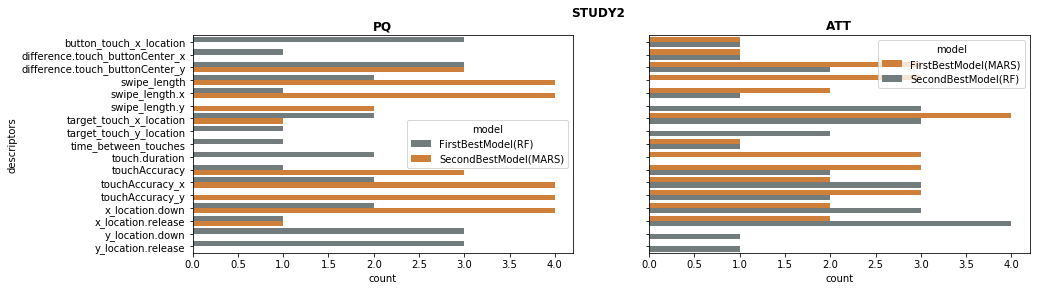

In [41]:
'''
TODO: plot the features only for 2 best models and 2 worst models
for PQ and ATT seperately
and then check in combination
'''
# for PQ
factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=False)
descriptors_details_by_models_3['Method']='GA_transformed'

factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_4['Method']='GA_transformed_PCA_0.80PC'


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4),sharey=True)
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,5))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='SVM',data=descriptors_details_by_models_4.sort_values(by='SVM', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,5))
# ax2.set_ylabel('Count')
# ax2.set_title('MARS')

# fig.suptitle('Ranking of important features for two best models for PQ',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='SVM', ascending=False)
# best2 = svm[svm['MARS']>1]['Descriptors'].values
# print("Common features selected for PQ are:\n",set(best1)&(set(best2)))

fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['RF'].values))
fs_scores.append(list(descriptors_details_by_models_4['MARS'].values))
descriptors=descriptors_details_by_models_3.index
# generate_heatmap_fs(descriptors,np.array(fs_scores).T,'PQ',ax1)
display_fs_count(descriptors,fs_scores,['FirstBestModel(RF)','SecondBestModel(MARS)'],'PQ',["#717D7E","#E67E22"],ax1)

# for ATT
target='ATT'
factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'
# 
factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets.csv')
df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
# descriptors_details_by_models_4
# descriptors_details_by_models_4['Method']='PCA_Transfromed_3PC'
descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'


fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
fs_scores.append(list(descriptors_details_by_models_4['RF'].values))
descriptors=descriptors_details_by_models_3.index
# generate_heatmap_fs(descriptors,np.array(fs_scores).T,'ATT',ax2)
display_fs_count(descriptors,fs_scores,['FirstBestModel(MARS)','SecondBestModel(RF)'],'ATT',["#E67E22","#717D7E"],ax2)
ax2.set_ylabel('')
fig.suptitle('STUDY2', weight='bold')
plt.show()

In [15]:
# summed= plot_df.groupby(by='Descriptors').mean().fillna(0).reset_index()#.sort_values(by='SVM',ascending=False)[['SVM','Descriptors']]
# plot_by_model(summed,'Features contributions in the selected PCs by Genetic Algorithm')

In [16]:
# plot_df_GA = pd.concat([descriptors_details_by_models_1,
#            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()
# summed= plot_df_GA.groupby(by='Descriptors').sum().fillna(0).reset_index()
# title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 2 dataset'
# plot_by_model(summed,'Base Features selected by Genetic Algorithm')

# # title='Mean ranking of descriptors from the original features during feature selection for STUDY 2 dataset'
# # plot(plot_df_GA,title)